In [ ]:
#### Import data / data prepration

In [ ]:
!pip install --quiet yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_datareader import data as pdr
import datetime as dt
from scipy import stats
import yfinance as yf  ### this is for fetching our data
import time

sns.set_style('whitegrid')  ## provide grid structure
%matplotlib inline

### Download our data

In [ ]:
# tickers = ['AAPL','MSFT','GOOGL','AMZN']
# weights = np.array([0.25,0.25,0.25,0.25])

# start = dt.datetime(2020,1,1)
# end = dt.datetime.today()

# price = pd.DataFrame(index=pd.date_range(start, end))
# print(price)




In [ ]:
ticker = ['AAPL','MSFT','GOOGL','AMZN']
weights = np.array([0.25,0.25,0.25,0.25])

start = dt.datetime(2020,1,1)
end = dt.datetime.today()

price = pd.DataFrame(index=pd.date_range(start,end))

# print(price)

for t in ticker:
  print(f"fetching{ticker}",end = "")
  try:
    ## featching the data
    df = yf.Ticker(ticker).history(start=start.strftime("%Y-%m-%d"),end = end.strftime("%Y-%m-%d"),auto_adjust=True,)
    series = df['Close']
    print("Y finance ",end="")
  except Exception as e:
    print(f"X yfinance ({e}); falling back to Stooq")
    df2 = pdr.DataReader(ticker,'stooq',start,end)
    df2 = df2.sort_index()
    series= df2['Close']

  price[ticker] = series
  time.sleep(1)

price = price.dropna(how='all').ffill().bfill()
print(price.tail())

fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance ('list' object has no attribute 'upper'); falling back to Stooq
fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance ('list' object has no attribute 'upper'); falling back to Stooq
fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance ('list' object has no attribute 'upper'); falling back to Stooq
fetching['AAPL', 'MSFT', 'GOOGL', 'AMZN']X yfinance ('list' object has no attribute 'upper'); falling back to Stooq
              AAPL    MSFT   GOOGL    AMZN
2025-05-14  212.33  452.94  165.37  210.25
2025-05-15  211.45  453.13  163.96  205.17
2025-05-16  211.26  454.27  166.19  205.59
2025-05-19  208.78  458.87  166.54  206.16
2025-05-20  206.86  458.17  163.98  204.07


### compute log return

In [ ]:
# log-return = ln(P_t / P_{t-1})
logR = np.log(price / price.shift(1)).dropna()
logR.head()

,AAPL,MSFT,GOOGL,AMZN
2020-01-03,-0.009737,-0.012360,-0.005243,-0.012213
2020-01-06,0.007879,0.002580,0.026304,0.014776
2020-01-07,-0.004666,-0.009299,-0.001935,0.002089
2020-01-08,0.015943,0.016008,0.007094,-0.007839
2020-01-09,0.021054,0.012240,0.010441,0.004788


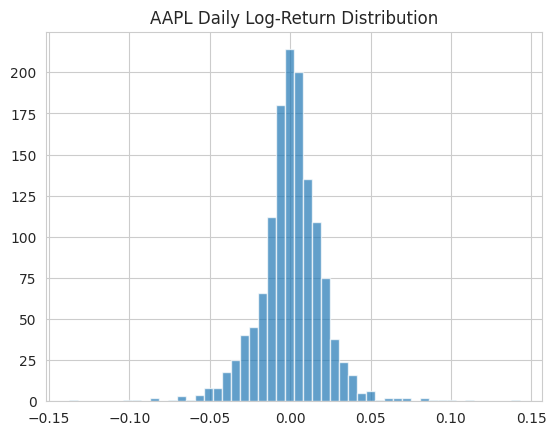

In [ ]:
# Plot one example series for visual Check
# You’ll see a bell-shaped histogram.
logR['AAPL'].hist(bins=50, alpha=0.7)
plt.title('AAPL Daily Log-Return Distribution')
plt.show()

Mean: average daily return

Variance: how much returns vary

Skewness: asymmetry (positive skew → fat right tail)

Kurtosis: tail-heaviness (high kurtosis → more extreme days)

In [ ]:
summary = pd.DataFrame({
    'Mean':    logR.mean(),
    'Variance':logR.var(),
    'Skewness':logR.skew(),
    'Kurtosis':logR.kurtosis()
})
summary

,Mean,Variance,Skewness,Kurtosis
AAPL,0.000773,0.000425,0.018529,6.231009
MSFT,0.000808,0.000373,-0.165383,7.423263
GOOGL,0.000649,0.000431,-0.225541,3.643160
AMZN,0.000566,0.000524,-0.069903,4.156126


Mean (≈0.05–0.08%): On average each stock’s daily return was very small—about a few‐tenths of a percent gain per day.**bold text**

Variance (≈0.0004): Typical daily swings are around √0.0004 ≃ 2%, so most days see moves of a couple percent.

Skewness (near zero or slightly negative): Returns are roughly symmetric, with a small tendency toward bigger down‐moves than up‐moves.

Kurtosis (>3): All four have “fat tails,” meaning they experience more extreme one‐day jumps or crashes than a normal bell curve would predict.

In [ ]:
## calculate U and std deviation
mu_norm, sigma_norm = logR.stack().mean(), logR.stack().std(ddof=1)
# 95% CI for mean under Normal: μ ± z*·σ/√N
N = logR.size
z95 = stats.norm.ppf(0.975)
ci_mu_norm = (mu_norm - z95*sigma_norm/np.sqrt(N),
              mu_norm + z95*sigma_norm/np.sqrt(N))


# 95% CI for σ via Chi-square:
df = N-1
chi2_low, chi2_high = stats.chi2.ppf([0.025,0.975], df)
ci_sigma_norm = (sigma_norm*np.sqrt(df/chi2_high),
                 sigma_norm*np.sqrt(df/chi2_low))

print("Normal fit:")
print(f"  μ = {mu_norm:.5f}, 95% CI {ci_mu_norm}")
print(f"  σ = {sigma_norm:.5f}, 95% CI {ci_sigma_norm}")

Normal fit:
  μ = 0.00070, 95% CI (np.float64(0.00014139280198295504), np.float64(0.0012570579483831934))
  σ = 0.02093, 95% CI (np.float64(0.020543110169780183), np.float64(0.021332338016669325))


In [ ]:
# 4.2 Fit Student’s t

# Fit t-distribution to the pooled returns
# returns_flat = all asset returns concatenated
returns_flat = logR.stack().values
df_t, mu_t, sigma_t = stats.t.fit(returns_flat)

In [ ]:
print(mu_t)

0.0010513834497300478


In [ ]:
B = 1000
estimates = np.array([stats.t.fit(np.random.choice(returns_flat, size=N, replace=True))
                      for _ in range(B)])
ci_mu_t    = np.percentile(estimates[:,1], [2.5,97.5])
ci_sigma_t = np.percentile(estimates[:,2], [2.5,97.5])

In [ ]:
print("\nStudent’s t fit:")
print(f"  df = {df_t:.1f}, μ = {mu_t:.5f},  σ = {sigma_t:.5f}")
print(f"  95% CI for μ (bootstrap): {ci_mu_t}")
print(f"  95% CI for σ (bootstrap): {ci_sigma_t}")


Student’s t fit:
  df = 3.6, μ = 0.00105,  σ = 0.01446
  95% CI for μ (bootstrap): [0.00060409 0.00150842]
  95% CI for σ (bootstrap): [0.0139776  0.01498278]


#### VAR With Normal dist

In [ ]:
portR= logR.dot(weights)

In [ ]:
portR

,0
2020-01-03,-0.009888
2020-01-06,0.012885
2020-01-07,-0.003453
2020-01-08,0.007801
2020-01-09,0.012131
...,...
2025-05-14,0.009061
2025-05-15,-0.009189
2025-05-16,0.004292
2025-05-19,0.000785


In [ ]:
μ_p = portR.mean()
σ_p = portR.std(ddof=1)

In [ ]:
### Zscore (0.05)
z05= stats.norm.ppf(0.05)

In [ ]:
# VAR with 95%
VAR_norm= -(μ_p + σ_p *z05)

In [ ]:
print(VAR_norm)

0.029196105452497914


## Using Student-t distribution

In [ ]:
t05 = stats.t.ppf(0.05,df_t)

In [ ]:
VaR_t = -(mu_t + sigma_t *t05) *1

In [ ]:
VaR_t



np.float64(0.030659101200691805)

## HISTORICAL METHOD

In [ ]:
### Historical VAR
hist_var = -np.percentile(portR,5)

In [ ]:

print("1-Day 95% VaR:")
print(f"  Parametric (Normal):       {VAR_norm:.5f}")
print(f"  Parametric (Student’s t):  {VaR_t:.5f}")
print(f"  Historical (5th percentile): {hist_var:.5f}")

1-Day 95% VaR:
  Parametric (Normal):       0.02920
  Parametric (Student’s t):  0.03066
  Historical (5th percentile): 0.02893


###   we found that on most days portpolio won't lost more then 2.9 to 3.1 %

#### Hypothesis Test

In [ ]:
t_stat, p_val = stats.ttest_1samp(portR, 0.0)

In [ ]:
print("One-sample t-test on portfolio daily returns:")
print(f"  t-statistic = {t_stat:.3f},  p-value = {p_val:.3f}")

One-sample t-test on portfolio daily returns:
  t-statistic = 1.415,  p-value = 0.157


In [ ]:
if p_val < 0.05:
    print("  → Reject H0: mean return is significantly different from zero.")
else:
    print("  → Fail to reject H0: no evidence mean return ≠ 0.")

  → Fail to reject H0: no evidence mean return ≠ 0.


Corelation matrix

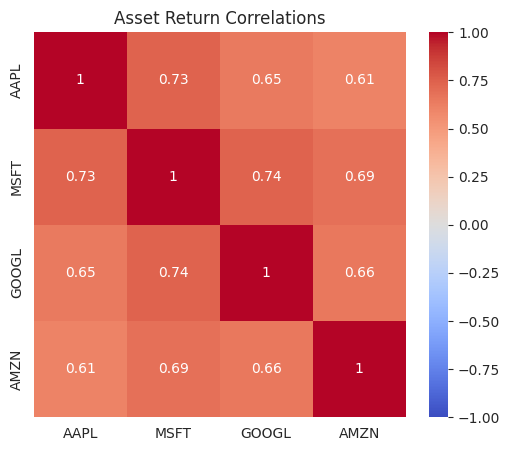

Weighted avg σ: 0.0209
Actual portfolio σ: 0.0182
Diversification benefit: 0.0027


In [ ]:
# 7. Correlation & Diversification Benefit
import seaborn as sns

# a) Correlation heatmap
corr = logR.corr()
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Asset Return Correlations')
plt.show()


# b) Diversification benefit
σ_i = logR.std()                         # individual volatilities
σ_weighted = np.dot(weights, σ_i)        # naive weighted avg
σ_portfolio = σ_p                        # from earlier
print(f"Weighted avg σ: {σ_weighted:.4f}")
print(f"Actual portfolio σ: {σ_portfolio:.4f}")
print(f"Diversification benefit: {σ_weighted-σ_portfolio:.4f}")

#### MDD/ DD

In [ ]:
# 8. Max Drawdown
cum_ret = (price / price.iloc[0]).prod(axis=1)  # cumulative portfolio growth?
# Actually for portfolio: cum_port = (portR + 1).cumprod()
cum_port = (portR + 1).cumprod()

In [ ]:
cum_port

,0
2020-01-03,0.990112
2020-01-06,1.002869
2020-01-07,0.999406
2020-01-08,1.007203
2020-01-09,1.019421
...,...
2025-05-14,2.084911
2025-05-15,2.065753
2025-05-16,2.074619
2025-05-19,2.076247


In [ ]:
# 2. Track the highest value reached so far
rolling_max = cum_port.cummax()

In [ ]:
rolling_max
drawdown   = (cum_port - rolling_max) / rolling_max

In [ ]:
max_dd = drawdown.min()
end_date = drawdown.idxmin()
start_date = cum_port[:end_date].idxmax()

In [ ]:
print(f"Max Drawdown: {max_dd:.2%}")
print(f"From {start_date.date()} to {end_date.date()}")

Max Drawdown: -43.98%
From 2021-12-10 to 2023-01-05


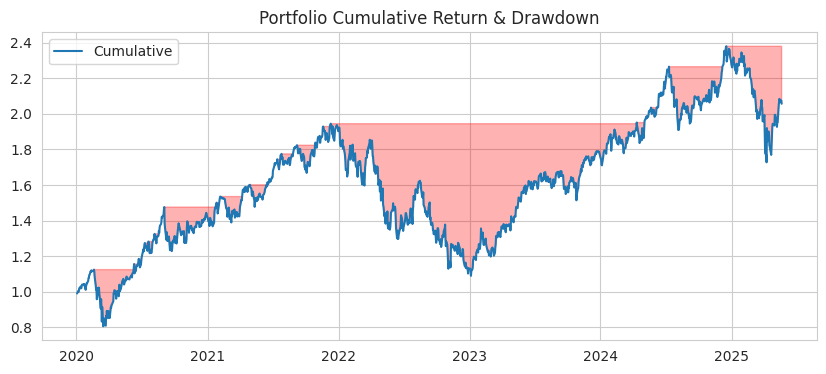

In [ ]:
# Plot
plt.figure(figsize=(10,4))
plt.plot(cum_port, label='Cumulative')
plt.fill_between(drawdown.index, cum_port, rolling_max,
                 where=drawdown<0, color='red', alpha=0.3)
plt.title('Portfolio Cumulative Return & Drawdown')
plt.legend()
plt.show()

### Expected shortfall / CVAR

In [ ]:
alpha = 0.5 ##  ES at beyond 95%
# historical
ES_historical = portR[portR <= np.percentile(portR, 5)].mean()

# normal method
ES_norm = (μ_p - σ_p * stats.norm.pdf(z05) / alpha)

print(f"Historical ES (95%): {ES_historical:.5f}")
print(f"Parametric Normal ES (95%): {ES_norm:.5f}")

Historical ES (95%): -0.04230
Parametric Normal ES (95%): -0.00305


### "VAR Backtesting"

In [ ]:
var_series= (portR.rolling(1).mean()  + portR.rolling(1).std()*z05)
### i am taking normal dist VAR
exc= portR <- VAR_norm
num_exc= exc.sum()

total =  len(portR)


print(f"Exceptions: {num_exc}/{total} days ({num_exc/total:.2%}, expected ~5%)")

Exceptions: 67/1352 days (4.96%, expected ~5%)


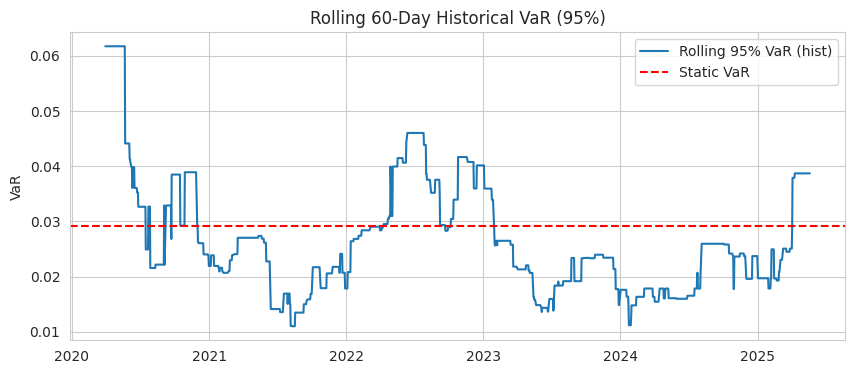

In [ ]:

# 11. Rolling 60-day VaR
window = 60
roll_var = portR.rolling(window).quantile(0.05).dropna()
plt.figure(figsize=(10,4))
plt.plot(-roll_var, label='Rolling 95% VaR (hist)')
plt.axhline(VAR_norm, color='red', linestyle='--', label='Static VaR')
plt.title('Rolling 60-Day Historical VaR (95%)')
plt.ylabel('VaR')
plt.legend()
plt.show()

In [ ]:
### Jarque bara test



jb_stat, jb_p = stats.jarque_bera(portR)
print(f"JB statistic = {jb_stat:.2f}, p-value = {jb_p:.3f}")
if jb_p < 0.05:
    print("Reject normality at 5% level.")
else:
    print("Cannot reject normality.")

JB statistic = 1185.36, p-value = 0.000
Reject normality at 5% level.
